# Theory

## Mathematical definition

Given the following parameters
- $N \in \mathbb{N} \dots$ *size parameter* (number of components)
- $\lambda \in \mathbb{R}_+ \dots$ *distribution paremeter* (rate parameter of exponential distribution)
- $\alpha \in [0, 1]\dots$ *localisation parameter* (window size of response function)
- $K \in [0, 1] \dots$ *interaction strength parameter* (coupling constant)

we construct a network on $N$ vertices as follows:
1. Each vertex $i$ is associated with a _position_ $\theta_i \sim \operatorname{WrapExp}(\lambda)$ drawn from a wrapped exponential distribution with rate parameter $\lambda$.
2. Now the edge probability for the two vertices $i$ and $j$ is given by the "positive part" of a linear function of the distance of $\theta_i$ and $\theta_j$, i.e.

$$p_{ij} 
= K \cdot 
\begin{cases}
\left| 1- \frac{\operatorname{d}\left(\theta_i, \theta_j\right)}{2\pi a} \right|_+ & \text{ for } a \leq 0.5, \\
\left| 1 - \frac{\operatorname{d}\left(\theta_i, \theta_j\right)}{2a\pi} \right|_+ + \left|\frac{\operatorname{d}\left(\theta_i, \theta_j\right)}{2a\pi} - \frac{(1-a)}{a} \right|_+ & \text{ for } a \geq 0.5 \\
\end{cases}
$$

where $d$ is the "circular distance" of two points, i.e. $d(x,y) = \min \big\{{|x-y|, 2\pi-|x-y|} \big\}$ and $|x|_+$ is the positive part, i.e. $|x|_+ = x$ for $x \geq 0$ and $|x|_+ = 0$ otherwise.

**Note:** The positions $\theta_i$ completely determine the probability matrix $P = (p_{ij})$ which (for $\lambda < \infty$) describes an _inhomogenious_ random graph model.

## Motivation behind the definitions

### Design choices

| principle | model implementation |
|  :-----:  |    :---:               |
|    elements ($N$)     | sample points / nodes |
| external signal ($\sigma_o$)  | origin |
| response to $\sigma_o$ | wrapped exponential distribution|
| response profile $(r_n)$ | box-function |
| internal state ($\sigma_i$)  | value of the box-function (either $1$ or $0$)|
| hysteresis of ($\sigma_o$) | periodicity of phase-space (?) |
| delay of $\sigma_i$           | position of the box-function |
| similar response profiles result in higher interaction probability | cosine similarity|

In [2]:
import numpy as np
import ringity as rng
import matplotlib.pyplot as plt

### Exponential response

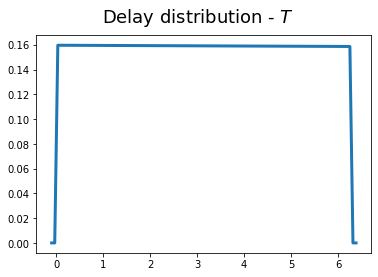

In [13]:
x = np.linspace(-0.1,2*np.pi+0.1,100)
rate = 0.001

plt.plot(x, rng.pdf_delay(x, rate, 'rate') , linewidth=3)

plt.suptitle("Delay distribution - $T$", fontsize=18);

### Case $a \leq 0.5$

In [4]:
def response(x, theta, alpha = 0.5):
    window_size = 2*np.pi*alpha
    return np.where(abs((x-theta) % (2*np.pi)) < window_size, 1, 0)

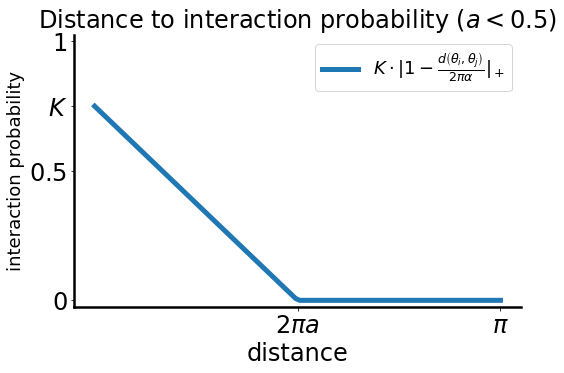

In [6]:
K = 0.75
a = 0.25

x = np.linspace(0, np.pi, 100)
y = K*(1-x/(2*np.pi*a)).clip(0)

fig, ax = plt.subplots(figsize = (8,5))

ax.set_title(r"Distance to interaction probability ($a < 0.5$)", fontsize = 24)
ax.plot(x, y, linewidth = 5, label = r"$K \cdot \left| 1- \frac{d\left(\theta_i, \theta_j\right)}{2\pi\alpha} \right|_+$")


plt.xticks([2*np.pi*a, np.pi], [r'$2\pi a$', r'$\pi$'])
plt.yticks([0, 0.5, 1, K], [r'$0$', r'$0.5$', r'$1$', r'$K$'])

ax.set_ylim(-0.025, 1.025)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('distance', fontsize=24)
ax.set_ylabel('interaction probability', fontsize=18)

rng.ax_setup(ax)

ax.legend(fontsize = 18);

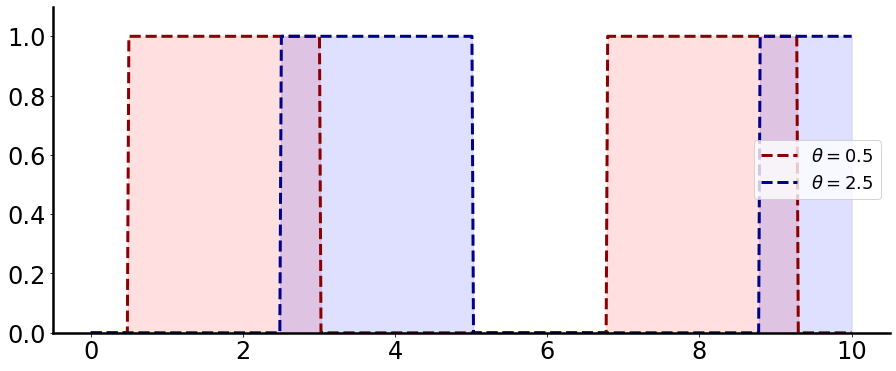

In [8]:
alpha = 0.4
theta1 = 0.5
theta2 = 2.5
x = np.linspace(0, 10, 500)

fig, ax = plt.subplots(figsize=(15,6))
ax.set_ylim(0, 1.1)

ax.plot(x, response(x, theta=theta1, alpha=alpha), '--', c = 'darkred', linewidth=3, label = rf'$\theta = {theta1}$');
ax.plot(x, response(x, theta=theta2, alpha=alpha), '--', c = 'darkblue', linewidth=3, label = rf'$\theta = {theta2}$');

ax.fill_between(x, response(x, theta=theta1, alpha=alpha), color = 'red', alpha = 0.125)
ax.fill_between(x, response(x, theta=theta2, alpha=alpha), color = 'blue', alpha = 0.125)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
rng.ax_setup(ax)
ax.legend(loc = 'center right', prop={'size': 18});

Assuming the response functions are elements of $r_i, r_j \in L^2([0, 2\pi])$ we can calculate the "cosine similarity" as

$$s_{i,j} = \frac{\langle r_i, r_j \rangle}{\|r_i \| \|r_j \|} = \left| 1 - \frac{d(\theta_i, \theta_j)}{2\pi \alpha} \right|_{+} \, ,$$

where $| x |_+$ is the _positive part_ of $x$, i.e. $|x|_+ = x$ for $x \geq 0$ and $|x|_+ = 0$ otherwise.

Since $s_{ij} \in [0,1]$ we can take $S = (s_{ij})$ already to define the random network. However, these networks tend to be densly connected and hence we introduce an additional parameter $K \in [0,1]$ to have more control over the overall connectivity by linearly scaling the similarities $P = K\cdot S$. The coupling constant $K$ is corresponds to the probability with which two components are interacting when they have exactly the same response function.

### Case $a \geq 0.5$

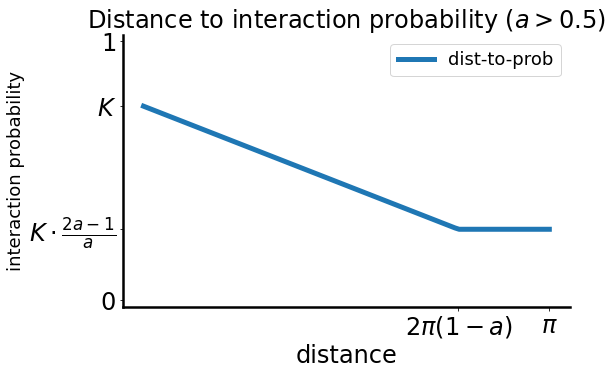

In [9]:
K = 0.75
a = 0.612

x = np.linspace(0, np.pi, 100)
y1 = rng.classes.network_model.box_cosine_similarity(x, box_length=2*a*np.pi)
y2 = rng.classes.network_model.linear_probability(y1, slope=K, intercept=0)

fig, ax = plt.subplots(figsize = (8,5))

ax.set_title(r"Distance to interaction probability ($a > 0.5$)", fontsize = 24)
ax.plot(x, y2, linewidth = 5, label = "dist-to-prob")


plt.xticks([2*np.pi*(1-a), np.pi], [r'$2\pi(1-a)$', r'$\pi$'])
plt.yticks([0, 1, K, K*(2*a-1) / a], [r'$0$', r'$1$', r'$K$', r'$K\cdot\frac{2a-1}{a}$'])

ax.set_ylim(-0.025, 1.025)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlabel('distance', fontsize=24)
ax.set_ylabel('interaction probability', fontsize=18)

rng.ax_setup(ax)

ax.legend(fontsize = 18);

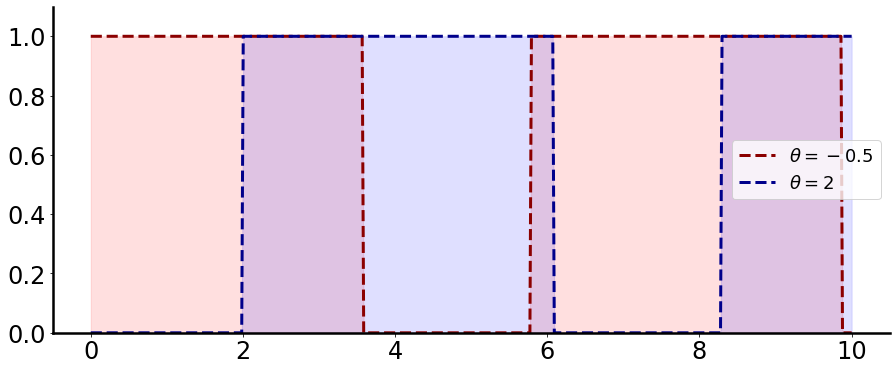

In [10]:
alpha = 0.65
theta1 = -0.5
theta2 = 2
x = np.linspace(0, 10, 500)

fig, ax = plt.subplots(figsize=(15,6))
ax.set_ylim(0, 1.1)

ax.plot(x, response(x, theta=theta1, alpha=alpha), '--', c = 'darkred', linewidth=3, label = rf'$\theta = {theta1}$');
ax.plot(x, response(x, theta=theta2, alpha=alpha), '--', c = 'darkblue', linewidth=3, label = rf'$\theta = {theta2}$');

ax.fill_between(x, response(x, theta=theta1, alpha=alpha), color = 'red', alpha = 0.125)
ax.fill_between(x, response(x, theta=theta2, alpha=alpha), color = 'blue', alpha = 0.125)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
rng.ax_setup(ax)
ax.legend(loc = 'center right', prop={'size': 18});

---

# FROM HERE ON ALL THE CALCULATIONS ARE DONE WITH $a \leq 0.5$

## Alternative parametrization

### Delay as normalized distribution parameter

We will introduce a _delay parameter_ $\beta$ to parametrize the exponential distribution with a bounded parameter $\beta \in [0,1]$ such that $\beta = 0$ results in the delta distribution at the origin ($\lambda \rightarrow \infty$), wheras $\beta = 1$ results in the uniform distribution $\lambda \rightarrow 0$. To that end, define the transformations
- $\beta = 1 - \frac{2}{\pi} \arctan(\lambda)$ --> use $\lambda$.
- $\lambda = \tan \left(\frac{\pi}{2}(1-\beta) \right)$

The parameter $\beta$ has the interpretation of a _response parameter_ of the internal states to an external signal. $\beta = 0$ means an immediate response of all internal states to the signal, whereas $\beta = 1$ results in no influence of internal states to the external stimulus. 

**Note 1:** For $\beta = 0$ the model "looses its heterogeneity" on the node level, forcing each node to behave the same. This system is _homogeneous_ and we recover the _Erdös-Renyi model_.

**Note 2:** For $\beta = 1$ the components are uniformly sampled on the circle and we obtain a _generalized geometric random graph_ with connection function specified by $p$. However, for $K \rightarrow \infty$ we recover the "classical" geometric random graph on the circle with a "hard cutoff" at $2\pi \alpha$.

### Network density as normalized coupling strength
**Governing equation:**
$\rho = K \cdot \mathbb{E}[S] = K \cdot \left(1 - \frac{\cosh(\lambda') - \cosh(\lambda'(1-2a))}{2a\lambda' \sinh(\lambda')} \right)$, \
where $\lambda' = \lambda\pi$.

For $a = \frac{1}{2}$ this reduces to
$$\rho = K \cdot \left(1 -  \frac{\tanh (\lambda' / 2)}{\lambda'} \right)$$

For $\lambda = 0$ this reduces to 
$$\rho = Ka$$

---
This suggests an alternative parametrization of the delay parameter as
$$\delta = 2\frac{\tanh (\lambda\pi / 2)}{\lambda\pi} = \frac{2}{\lambda\pi} \frac{\sinh(\pi\lambda)}{\cosh(\pi\lambda)+1}$$

### Discontinous jump at $\beta = 0$ (lack of phase transition)

**Theorem:** For any $\beta > 0$ the network becomes "ringy" for sufficiently large $N$.

**Proof (sketch):**
The network becomes "ringy" with probability
$$\operatorname{\mathbb{P}}\left[\text{network forms a ring}\right] = 1 - \left( 1 - \frac{K}{\alpha \lambda'} \cdot \frac{1 - e^{\alpha \lambda'} + \alpha\lambda'}{1 - e^{\lambda'}} \right)^N \,$$
with $\lambda' = 2\pi\lambda$.

A quick calculation shows that
$$T(\lambda') = K \left(\frac{1}{\alpha x} \cdot \frac{1 - e^{\alpha x} + \alpha \lambda'}{1 - e^{\lambda'}} \right)
\xrightarrow{\lambda' \rightarrow 0} \frac{K\alpha}{2} > 0 \, $$

and hence, for any constant $K$ and $\alpha$ the probability of the network forming a ring approaches $1$ as $N \rightarrow \infty$ and $\beta \rightarrow 1$.

Conversely, we have

$$T(\lambda') \xrightarrow{\lambda' \rightarrow \infty} 0 \, $$
and hence the nework does not form a ring for $\beta \rightarrow 0$. 

The term $T(x)$ is positive for $x < \infty$ and hence the network will eventually become circular. $\square$

## Parameter tables

### Model parameters
|  parameter | physical model         | mathematical model   | network model |
|  :-----:  |    :---:               |:---:                 |:---:          |
|    N      | nb. of elements        | nb. of sample points | nb. of nodes |
|  K / $\rho$ | coupling strength | y-intercept of "_interaction probability function_" | local density                                |
| a / $\alpha$  | localisation | x-intercept of "_interaction probability function_" | homogeneity of connections |
| $\lambda$ / $\beta$ / $\delta$  | synchronization to external response  | shape of distribution | homogeneity of nodes |

---

# Theory expansion [UNDER CONSTRUCTION]

## As a statistical interaction network model

Fixed parameters of the model are:
 - an _internal state spce / response space / local microstates_, $\sigma_{\mathit int} = \{ 0, 1\}$
 - an _external state space_, $\sigma_{\mathit ext} = [ 0, 2\pi]$
 - position distribution of elements / components / statistical units, $X_i \sim WExp(\lambda)$
 - a connection function, 
$p:\sigma_{\mathit ext} \times \sigma_{\mathit ext} \rightarrow [0,1]: (\theta_i, \theta_j) \mapsto \min \Big\{1, k - \frac{k}{2\pi a}d(\theta_i, \theta_j) \Big\}$,

where $d(.,.)$ is the "_periodic distance_", i.e. $d(\theta_i, \theta_j) = \min {\Big\{ \big|\theta_i-\theta_j\big|, 2\pi-\big|\theta_i-\theta_j\big|} \Big\}$

## As an Ising model with a "_random lattice_"

---
**Pending Thoughts**

I think the Ising model makes more sense for the "line graph", i.e. where the edges represent components and nodes define interactions.

---

Given the three parameters $N$, $a$ and $\beta$ we can construct a "_random lattice_" $\Lambda$ via:
$$\langle ij \rangle \Leftrightarrow d(\Theta_i, \Theta_j) < 2\pi a \, , \text{where } \Theta_k \sim \mathit WExp (\lambda)$$

## As a Generalized random geometric graph (RGG)

The connection fucntion is taken from the "_Quasi unit disk model_" via
$$H(d) =
    \begin{cases}
      1, & \text{if}\ d \leq d_- \\
      \frac{d_+ - d}{d_+ - d_-}, & \text{if}\ d_- \leq d \leq d_+ \\
      0, & \text{if}\ d \geq d_+
    \end{cases} \, ,$$ 
    
where $d_- = 2\pi a (1-1/k)$ and $d_+ = 2$. 

The small $d$ expansion is the constant $1$ (similar to a random geometric graph model with a "hard" cutoff).

## References
- Dettmann, Carl P., and Orestis Georgiou. "Random geometric graphs with general connection functions." Physical Review E 93.3 (2016): 032313.
- Kuhn, F., R. Wattenhofer, and A. Zollinger. "Proceedings of the 2003 Joint Workshop on Foundations of Mobile Computing." (2003): 69-78.
- Gao, Deyun, et al. "Hop-distance relationship analysis with quasi-UDG model for node localization in wireless sensor networks." EURASIP Journal on Wireless Communications and Networking 2011.1 (2011): 1-11